# Null model : This model assumes that individual reads sit on completely random position on the reference genome

In [1]:
import Pkg

In [2]:
using PyPlot,Random,LsqFit

In [3]:
len_genome=1e7 # length of genome: 1e7
len_read=100 # length of read
n_read=len_genome/len_read # no. of reads
n_read=Int64(n_read) 
sim=rand(1:1e7,n_read);  # Using random the starting positions of reads of length 100 are simulated and stored in an array

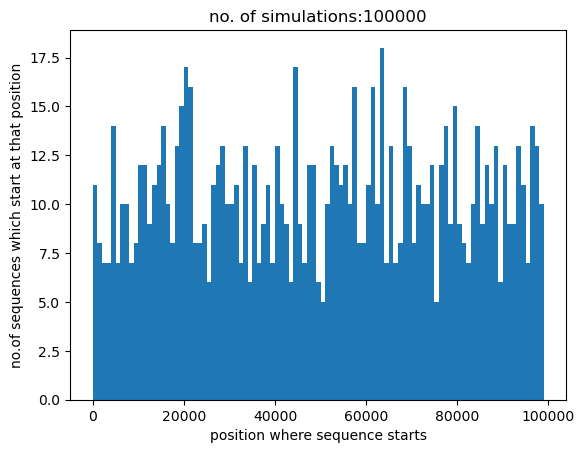

PyObject Text(0.5, 1.0, 'no. of simulations:100000')

In [4]:
hist(sim,bins=1:1000:1e5)
xlabel("position where sequence starts")
ylabel("no.of sequences which start at that position")
title("no. of simulations:"*string(n_read))

# Simulation of random reads onto the reference genome

## we simulate the starting position of a read and add 1.0 to next 100 positions as well. so the final array which we obtain we will have no. of coverages above a particular location. The array will look like  [1, 2, 3, 3, 3, 2, 2, 2, 2, 1, 1] , by visual inspection for coverage 1 we have 2 regions of length 1 and 2. For coverage 2 the lengths will be 1 and 4. For coverage 3 the lengths will be 3 alone. The below code just finds the length of these regions and plots are plotted.

In [33]:
function reads_on_genome(n_reads)
    len_genome=Int32(1e7) # length of genome
    len_read=100 # length of a read
    #n_reads=Int32(4*len_genome/len_read) # no. of reads
    genome=zeros(Int32,len_genome) # genome 
    for i in 1:n_reads
        j=rand(1:len_genome-100)
        genome[j]+=1
        genome[j+100] -= 1
    end
    # integrating the derivative array
    for pos in 2:len_genome
      genome[pos]=genome[pos]+genome[pos-1]
    end
    return genome
end

reads_on_genome (generic function with 2 methods)

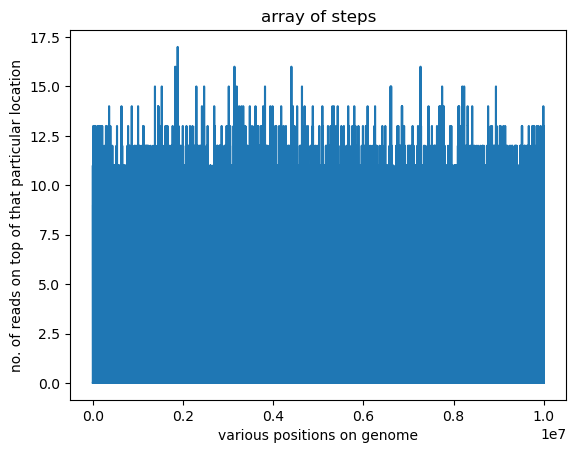

PyObject Text(24.00000000000002, 0.5, 'no. of reads on top of that particular location')

In [6]:
a=reads_on_genome()
plot(1:length(a),a)
title("array of steps")
xlabel("various positions on genome")
ylabel("no. of reads on top of that particular location")

# Function to find lengths for various overlaps : we want to find the lengths of regions with a particular overlap.

In [34]:
function heights_to_overlap_lengths_dict(genome)
    length_dict = Dict{Int, Vector{Int}}()
    length_overlap=1
    overlap=genome[1]
    length_genome=length(genome)
    for i in 2:length_genome
      if genome[i]==overlap
          length_overlap+=1
      else
          if length_overlap>0
              push!(get!(length_dict, overlap, Int[]), length_overlap)
          length_overlap=1
          overlap=genome[i]
          end
      end
    end
  return length_dict
  end

heights_to_overlap_lengths_dict (generic function with 1 method)

In [8]:
 heights_to_overlap_lengths_dict(a)

Dict{Int64, Vector{Int64}} with 18 entries:
  5  => [4, 5, 9, 19, 1, 4, 14, 18, 14, 10  …  8, 32, 6, 7, 26, 24, 6, 11, 4, 1…
  16 => [7, 16, 12, 11, 2, 2, 1, 8]
  12 => [3, 2, 6, 19, 7, 6, 13, 9, 25, 1  …  12, 4, 16, 9, 12, 13, 2, 1, 12, 2]
  8  => [21, 11, 30, 1, 10, 6, 4, 6, 6, 39  …  3, 12, 9, 6, 22, 8, 8, 1, 5, 8]
  17 => [10]
  1  => [20, 26, 5, 28, 14, 47, 8, 18, 31, 47  …  50, 27, 58, 5, 9, 17, 4, 3, 1…
  0  => [10, 7, 16, 20, 10, 8, 18, 1, 5, 5  …  8, 2, 3, 38, 12, 3, 33, 32, 12, …
  6  => [19, 9, 21, 25, 8, 2, 9, 2, 35, 35  …  9, 7, 15, 19, 3, 6, 1, 26, 2, 9]
  11 => [5, 3, 7, 32, 3, 5, 6, 4, 1, 20  …  19, 3, 6, 3, 2, 2, 6, 12, 10, 2]
  9  => [8, 6, 8, 2, 21, 5, 5, 3, 15, 9  …  2, 8, 5, 6, 6, 7, 11, 18, 9, 1]
  14 => [9, 2, 5, 13, 9, 1, 8, 5, 1, 17  …  14, 6, 1, 1, 2, 1, 2, 8, 2, 10]
  3  => [4, 17, 15, 21, 10, 4, 8, 6, 26, 28  …  1, 16, 48, 9, 8, 14, 1, 16, 11,…
  7  => [23, 20, 15, 10, 2, 8, 3, 2, 2, 4  …  17, 1, 11, 13, 1, 8, 7, 25, 1, 3]
  4  => [4, 4, 4, 10, 5, 18, 3, 3, 

In [9]:
h= heights_to_overlap_lengths_dict(a);

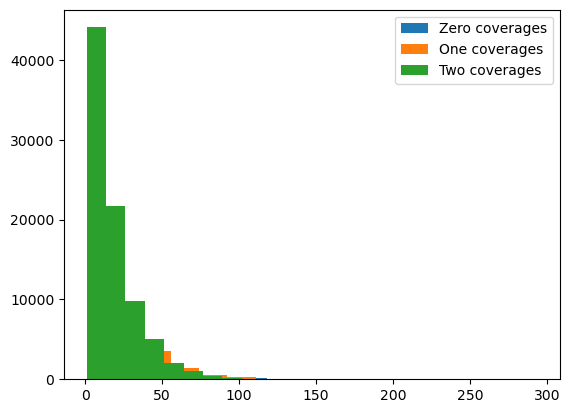

In [18]:
hist(h[0],label="Zero coverages")
hist(h[1],label="One coverages")
hist(h[2],label="Two coverages")
legend()
show()

# Fitting the simulated data of lengths belonging to regions of a particular overlap to an exponential function

In [27]:
function plot_exp_fit(n_reads,overlap,str)
    lengths_for_a_particular_overlap=[]
    for i in 1:2
        genome=reads_on_genome(n_reads)
        lengths_for_a_particular_overlap=vcat(lengths_for_a_particular_overlap, heights_to_overlap_lengths_dict(genome)[overlap])
    end
    
    y_simulation=fill(0.0,maximum(lengths_for_a_particular_overlap))
    for i in lengths_for_a_particular_overlap
        y_simulation[i]+=1
    end
    
    y_simulation=y_simulation./2
    lengths=Float64[i for i in 1:maximum(lengths_for_a_particular_overlap)]
    lengths=lengths[1:100]
    y_simulation=y_simulation[1:100]
    
    m(x, p) = p[1] * exp.(p[2] * x)
    p0 = [0.5, 0.5]
    fit0=curve_fit(m,lengths,y_simulation,p0)
    p0=fit0.param
    y_prediction=p0[1]*exp.(p0[2]*lengths)
    
    print(fit0.param)
    figure(figsize=(10,5))
    scatter(lengths,log.(y_simulation),label="Simulated data")
    scatter(lengths,log.(y_prediction),label="Exponential fit")
    title(str*" coverages")
    
end

plot_exp_fit (generic function with 1 method)

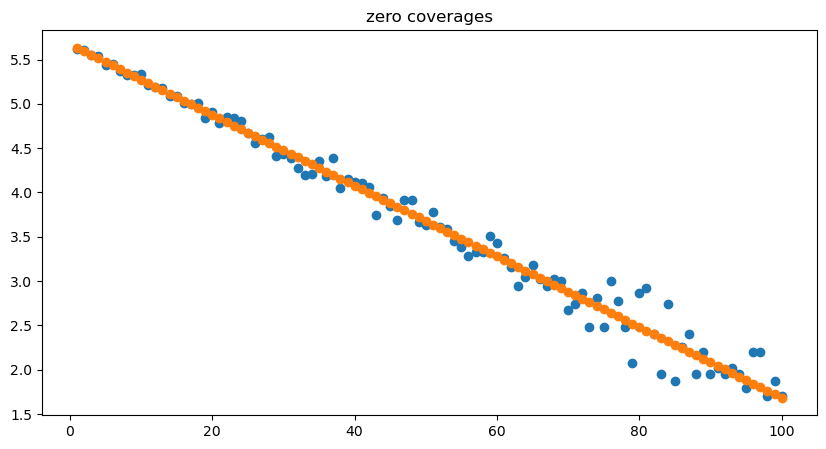

[290.670728459113, -0.03989421991651333]

PyObject Text(0.5, 1.0, 'zero coverages')

In [28]:
plot_exp_fit(0,"zero")

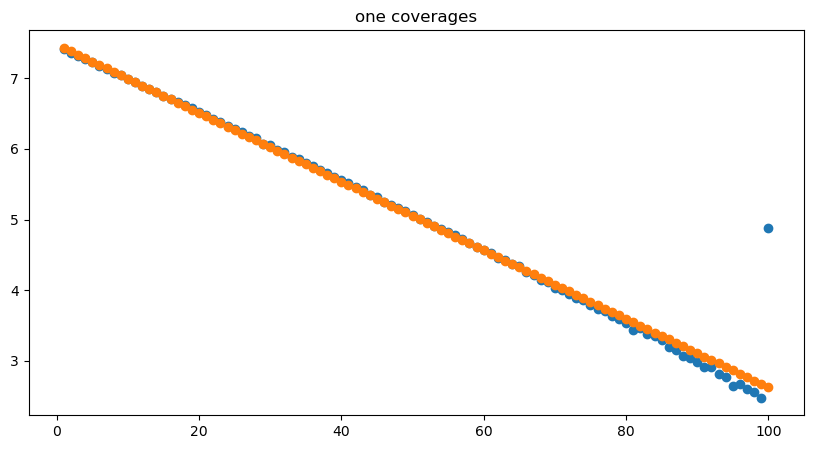

PyObject Text(0.5, 1.0, 'one coverages')

In [48]:
plot_exp_fit(1,"one")

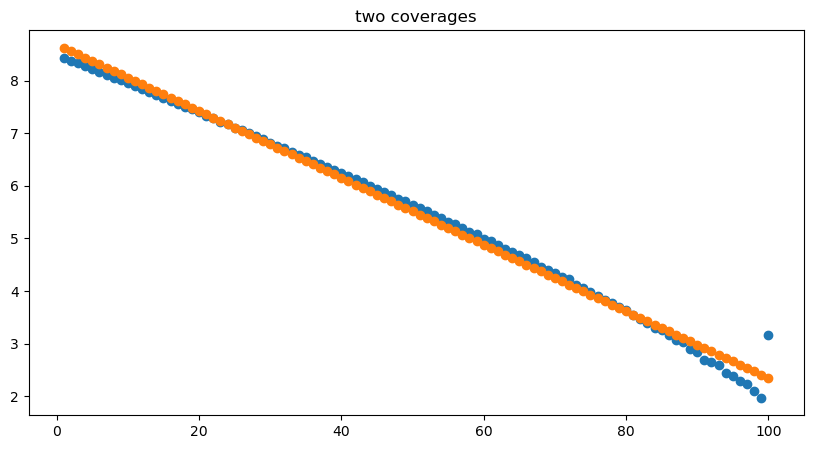

PyObject Text(0.5, 1.0, 'two coverages')

In [49]:
plot_exp_fit(2,"two")

# Modelling the slope of exponential fit vs no. of reads

In [97]:
function param_exp_fit(n_reads,overlap)
    lengths_for_a_particular_overlap=[]
    for i in 1:10
        genome=reads_on_genome(n_reads)
        lengths_for_a_particular_overlap=vcat(lengths_for_a_particular_overlap, heights_to_overlap_lengths_dict(genome)[overlap])
    end
    
    y_simulation=fill(0.0,maximum(lengths_for_a_particular_overlap))
    for i in lengths_for_a_particular_overlap
        y_simulation[i]+=1
    end
    
    y_simulation=y_simulation./10
    lengths=Float64[i for i in 1:maximum(lengths_for_a_particular_overlap)]
    stop=findmin(y_simulation)[2]
    lengths=lengths[1:stop]
    y_simulation=y_simulation[1:stop]
    #print(stop)
    m(x, p) = p[1] * exp.(p[2] * x)
    p0 = [0.5, 0.5]
    fit0=curve_fit(m,lengths,y_simulation,p0)
    return (fit0.param)
    
end

param_exp_fit (generic function with 2 methods)

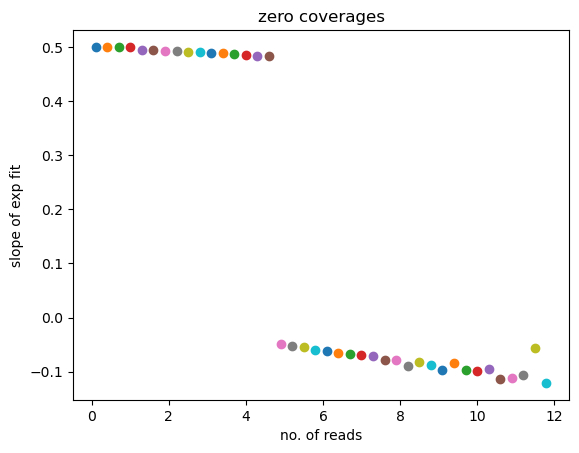

In [99]:
len_genome=1e7 # length of genome: 1e7
len_read=100 # length of read
for i in 0.1:0.3:12
    #print(i)
    n_read=i*len_genome/len_read # no. of reads
    n_read=Int64(n_read) 
    #print(param_exp_fit(n_read,0)[2])
    #print("\n")
    scatter(i,param_exp_fit(n_read,0)[2])
end
title("zero coverages")
xlabel("no. of reads")
ylabel("slope of exp fit")
show()

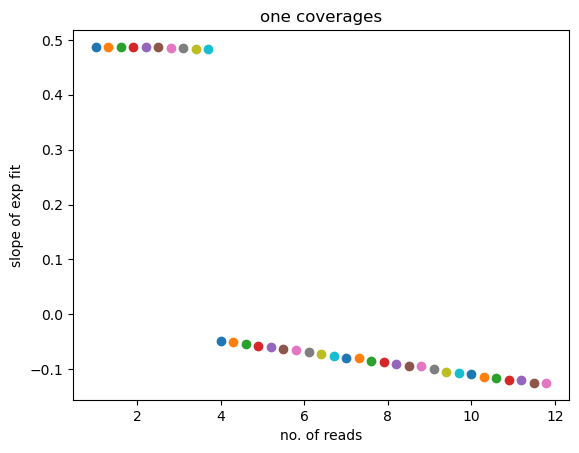

In [100]:
len_genome=1e7 # length of genome: 1e7
len_read=100 # length of read
for i in 1:0.3:12
    n_read=i*len_genome/len_read # no. of reads
    n_read=Int64(n_read) 
    scatter(i,param_exp_fit(n_read,1)[2])
end
title("one coverages")
xlabel("no. of reads")
ylabel("slope of exp fit")
show()

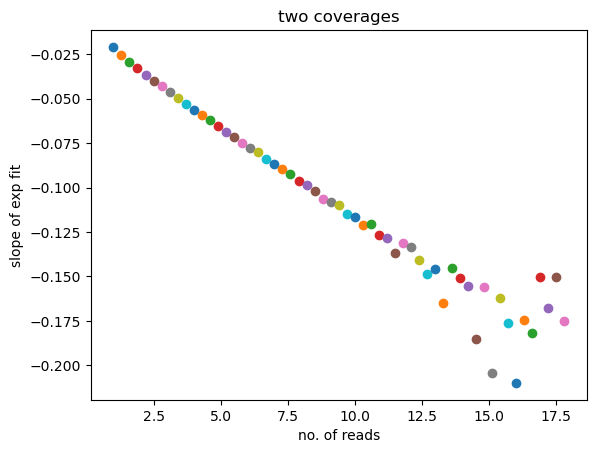

In [101]:
len_genome=1e7 # length of genome: 1e7
len_read=100 # length of read
for i in 1:0.3:18
    #print(i)
    n_read=i*len_genome/len_read # no. of reads
    n_read=Int64(n_read) 
    #print(param_exp_fit(n_read,0)[2])
    #print("\n")
    scatter(i,param_exp_fit(n_read,2)[2])
end
title("two coverages")
xlabel("no. of reads")
ylabel("slope of exp fit")
show()